# Model

## Imports

In [1]:
import pandas as pd
import numpy as np

In [2]:
from typing import List, Callable
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings(action='ignore')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
)
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import (r2_score, mean_absolute_error)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    cross_val_score,
    KFold,
    TimeSeriesSplit,
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

## Load Dataset

In [5]:
train_x = pd.read_pickle(f'dataset/summary/train_x_summary.pkl')
test_x = pd.read_pickle(f'dataset/summary/test_x_summary.pkl')
train_y = pd.read_csv('dataset/train_y.csv')

### Remove Outliers

- Use `p99` summary value (Try and Error)

In [6]:
drop = [25, 119, 264, 301]  # Outliers found in EDA
summary = 'p99'
train_x = train_x[summary].drop(drop, axis=0)
test_x = test_x[summary]
x_arr = train_x.to_numpy()

In [7]:
train_y = train_y.drop(drop, axis=0)
y_arr = train_y['y']

## Model Building

In [8]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html
from matplotlib.patches import Patch

def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )

    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=range(1, n_splits+1),
        xlabel="ID",
        ylabel="CV iteration",
        ylim=[n_splits, -0.2],
        xlim=[0, 403],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    ax.legend(
        [Patch(color=plt.cm.coolwarm(0.8)), Patch(color=plt.cm.coolwarm(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
    plt.show()
    
def plot_result(y_true: np.ndarray, y_pred: np.ndarray,
                figwidth: int=15, margin: float=1.0) -> None: 
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Results in Training Set')
    fig.set_figwidth(figwidth)
    ax1.plot(y_true, label='y_true')
    ax1.plot(y_pred, label='y_pred')
    ax1.set_xlabel('ID')
    ax1.set_ylabel('y')
    ax1.legend()

    ax2.scatter(x=y_true, y=y_pred)
    ax2.margins(x=0, y=0)
    ax2.set_xlabel('y_true')
    ax2.set_ylabel('y_pred')
    x = np.linspace(y_pred.min()-margin, y_pred.max()+margin, 100)
    y_ = x
    ax2.plot(x, y_, '-r')
    plt.show()

### Compare Cross Validation Methods

> "The number of folds is usually determined by the number of instances contained in your dataset."
> https://datascience.stackexchange.com/questions/28158/how-to-calculate-the-fold-number-k-fold-in-cross-validation

In [9]:
# Default Settings
N_SPLITS = 5
N_ITER = 100

#### KFold

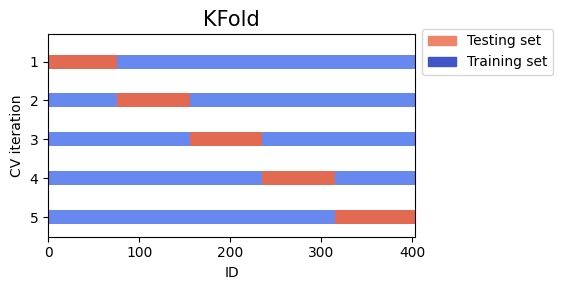

In [10]:
kf = KFold(n_splits=N_SPLITS)
fig, ax = plt.subplots(figsize=(6, 3))
plot_cv_indices(kf, x_arr, y_arr, ax, N_SPLITS)

#### Time Series Split

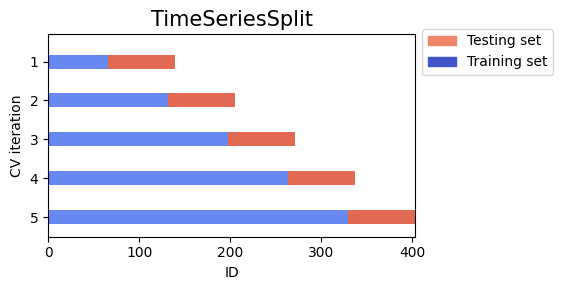

In [11]:
ts = TimeSeriesSplit(n_splits=N_SPLITS)
fig, ax = plt.subplots(figsize=(6, 3))
plot_cv_indices(ts, x_arr, y_arr, ax, N_SPLITS)

### Modeling

- Summary: **p99**
- CV: 데이터형태가 시계열이기 때문에 **`TimeSeriesSplit`** 이 적합할것임
- Hyperparameter Tuning: **`RandomizedSearchCV`**

In [12]:
def compare_model(cv_res: dict) -> pd.DataFrame:
    compare_table = (pd.DataFrame(cv_res)
                     .reset_index(names='estimator'))
    return compare_table.sort_values('best_score')

In [13]:
metrics = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
}

#### Model 1 - **Regression Family**

- Feature Engineering: **None**

In [14]:
%%time
model_list = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
]
best_params = {}
best_scores = {}

for model in model_list:
    model_name = str(model)
    estimator = model_name.replace('()', '')
    params = {
        'alpha': np.arange(0, 1, 0.05),
        'max_iter': np.arange(1000, 5000, 1000),
    }
    cv = TimeSeriesSplit(N_SPLITS)
    if estimator != 'LinearRegression':
        if estimator == 'ElasticNet':
            params['l1_ratio'] = np.arange(0, 1, 0.1)

        rand_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=params,
            n_iter=N_ITER,
            cv=cv,
            scoring=metrics['mae'],
            n_jobs=-1,
        )
        rand_search.fit(x_arr, y_arr)

        best_params[estimator] = rand_search.best_params_
        best_scores[estimator] = rand_search.best_score_ * -1
    else:
        # Linear Regression
        res = cross_validate(model, x_arr, y_arr, cv=cv, scoring=metrics['mae'])
        mae = res['test_score'] * -1
        mae_avg = np.mean(mae)
        best_scores[estimator] = mae_avg
cv_res = {
    'best_param': best_params,
    'best_score': best_scores,
}

CPU times: total: 1.55 s
Wall time: 25 s


In [15]:
compare_table = compare_model(cv_res)
compare_table

,estimator,best_param,best_score
2,ElasticNet,"{'max_iter': 1000, 'l1_ratio': 0.2, 'alpha': 0.5}",0.187307
1,Lasso,"{'max_iter': 1000, 'alpha': 0.1}",0.187543
0,Ridge,"{'max_iter': 1000, 'alpha': 0.9500000000000001}",0.211774
3,LinearRegression,NaN,0.212110


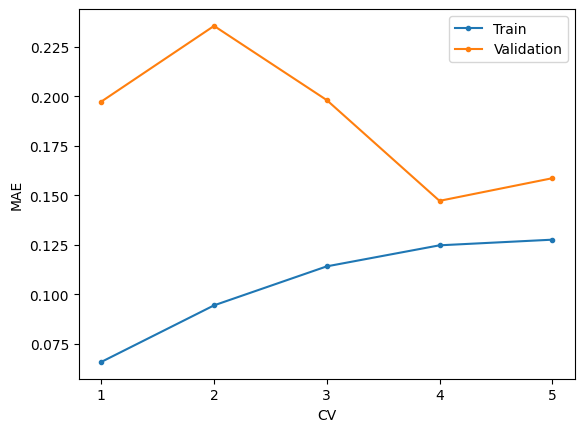

In [16]:
cv = TimeSeriesSplit(n_splits=N_SPLITS)
hyperparams = compare_table['best_param'].iloc[0]
model = eval(compare_table['estimator'].iloc[0])
cv_results = cross_validate(
    model(**hyperparams),
    x_arr,
    y_arr,
    cv=cv,
    scoring=metrics['mae'],
    return_train_score=True,
)
plt.plot(cv_results['train_score'] * -1, marker='o', markersize=3, label='Train')
plt.plot(cv_results['test_score'] * -1, marker='o', markersize=3, label='Validation')
plt.xticks(range(0, N_SPLITS), range(1, N_SPLITS + 1))
plt.xlabel('CV')
plt.ylabel('MAE')
plt.legend();

#### Model 2 - **Principal Component Regression**

- Feature Engineering: **PCA**

In [17]:
%%time
model_list = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
]
best_params = {}
best_scores = {}
pipelines = {}
for model in model_list:
    model_name = str(model)
    estimator = model_name.replace('()', '')
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('PCA', PCA()),
        ('regression', model)
    ])
    params = {
        'PCA__n_components': list(range(1, 404)),
        'regression__alpha': np.arange(0, 1, 0.05),
        'regression__max_iter': np.arange(1000, 5000, 1000),
    }
    cv = TimeSeriesSplit(N_SPLITS)
    if estimator == 'LinearRegression':
        params = {
            'PCA__n_components': list(range(1, 404))
        }
    elif estimator == 'ElasticNet':
        params['regression__l1_ratio'] = np.arange(0, 1, 0.1)

    rand_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=params,
        n_iter=N_ITER,
        cv=cv,
        scoring=metrics['mae'],
    )
    rand_search.fit(x_arr, y_arr)
    best_params[estimator] = rand_search.best_params_
    best_scores[estimator] = rand_search.best_score_ * -1
    pipelines[estimator] = pipeline

cv_res = {
    'pipeline': pipelines,
    'best_param': best_params,
    'best_score': best_scores,
}

CPU times: total: 1min 36s
Wall time: 58.8 s


In [18]:
compare_table = compare_model(cv_res)
compare_table

,estimator,pipeline,best_param,best_score
2,Lasso,"(StandardScaler(), PCA(), Lasso())","{'regression__max_iter': 3000, 'regression__al...",0.191052
0,LinearRegression,"(StandardScaler(), PCA(), LinearRegression())",{'PCA__n_components': 31},0.191232
1,Ridge,"(StandardScaler(), PCA(), Ridge())","{'regression__max_iter': 3000, 'regression__al...",0.192491
3,ElasticNet,"(StandardScaler(), PCA(), ElasticNet())","{'regression__max_iter': 4000, 'regression__l1...",0.192857


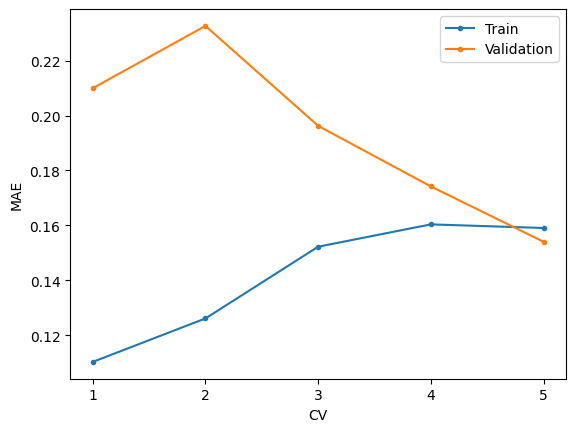

In [19]:
best_pipeline = compare_table.iloc[0]
pipeline = best_pipeline['pipeline'].set_params(**best_pipeline['best_param'])
cv = TimeSeriesSplit(n_splits=N_SPLITS)
cv_results = cross_validate(
    pipeline,
    x_arr,
    y_arr,
    cv=cv,
    scoring=metrics['mae'],
    return_train_score=True,
)
plt.plot(cv_results['train_score'] * -1, marker='o', markersize=3, label='Train')
plt.plot(cv_results['test_score'] * -1, marker='o', markersize=3, label='Validation')
plt.xticks(range(0, N_SPLITS), range(1, N_SPLITS + 1))
plt.xlabel('CV')
plt.ylabel('MAE')
plt.legend();

#### Model 3 - **Partial Least Squares Regression**

In [20]:
model = PLSRegression()
params = {
    'n_components': list(range(1, 404)),
}
cv = TimeSeriesSplit(n_splits=N_SPLITS)
rand_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=params,
    n_iter=N_ITER,
    cv=cv,
    scoring=metrics['mae'],
)
rand_search.fit(x_arr, y_arr)
best_params = rand_search.best_params_
best_scores = rand_search.best_score_ * -1
print(best_params)
print(best_scores)

{'n_components': 11}
0.19966785307364146


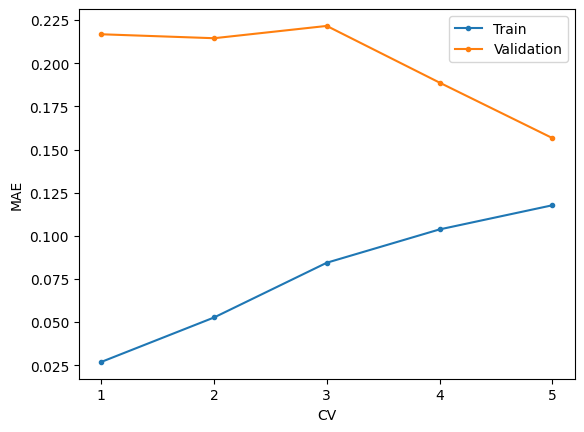

In [21]:
cv = TimeSeriesSplit(n_splits=N_SPLITS)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regression', PLSRegression(best_params['n_components'])),
])
cv_results = cross_validate(
    pipeline,
    x_arr,
    y_arr,
    cv=cv,
    scoring=metrics['mae'],
    return_train_score=True,
)
plt.plot(cv_results['train_score'] * -1, marker='o', markersize=3, label='Train')
plt.plot(cv_results['test_score'] * -1, marker='o', markersize=3, label='Validation')
plt.xticks(range(0, N_SPLITS), range(1, N_SPLITS + 1))
plt.xlabel('CV')
plt.ylabel('MAE')
plt.legend();

### Final Model

- Validation Score이 가장 안정적인 PLS 모델 선정

In [22]:
%%time
pls_output = {}
for i in range(1, 31):
    try:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('regression', PLSRegression(i)),
        ])
        cv = TimeSeriesSplit(n_splits=N_SPLITS)
        res = cross_val_score(pipeline, x_arr, y_arr, cv=cv, scoring='neg_mean_absolute_error')
        avg_score = res.mean() * -1
        pls_output[i] = avg_score
    except Exception as e:
        print(e)
pls_output = pd.Series(pls_output).to_frame()

CPU times: total: 2.69 s
Wall time: 2.79 s


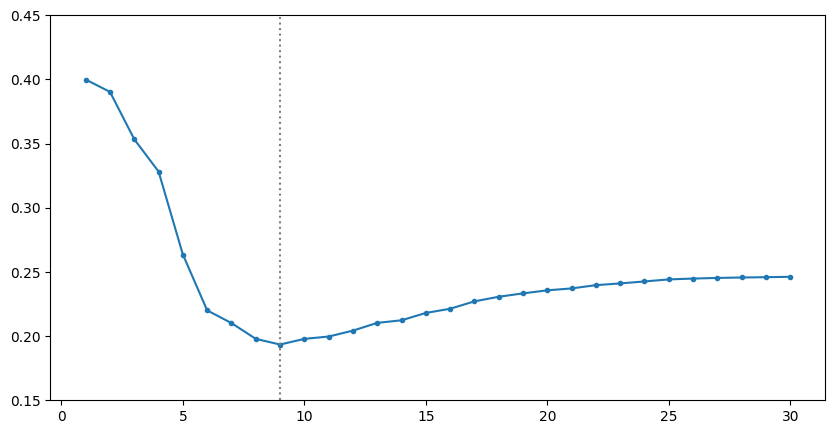

n_component: 9
MAE: 0.19342673746104486


In [23]:
plt.figure(figsize=(10, 5))
plt.plot(pls_output, marker='o', markersize=3)
best_n_component = np.argmin(pls_output) + 1
plt.vlines(best_n_component, ymin=0.15, ymax=0.45, color='gray', linestyle='dotted')
plt.margins(y=0)
plt.show()
print(f'n_component: {pls_output.loc[best_n_component].name}\nMAE: {pls_output.loc[best_n_component][0]}')

In [24]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regression', PLSRegression(n_components=best_n_component)),
])

cv = TimeSeriesSplit(n_splits=N_SPLITS)
scoring = 'mae'
res = cross_val_score(pipeline, x_arr, y_arr, cv=cv, scoring=metrics[scoring])
metric_avg = np.mean(res) * -1
print(f"[Average Metric] {scoring}: {metric_avg:.4f}")

[Average Metric] mae: 0.1934


In [25]:
pipeline.fit(x_arr, y_arr)
y_pred = pipeline.predict(test_x)
id_col = pd.Series(test_x.index)
pred_col = pd.Series(y_pred.ravel(), name='y_prediction')
submit_pred = pd.concat([id_col, pred_col], axis=1)
submit_pred.to_csv('submission/submission.csv', index=False)